# Planificación: Dyna-Q (TD)

En este notebook implementaremos el algoritmo Dyna-Q, que combina aprendizaje por refuerzo y planificación. Este enfoque utiliza la experiencia del agente para actualizar su modelo del entorno y luego simula experiencias adicionales basadas en ese modelo. Usaremos lo aprendido en Q-learning y lo compararemos con el algoritmo Dyna-Q.

## Objetivos

- Implementar el algoritmo Dyna-Q.
- Comparar el rendimiento de Dyna-Q con Q-learning.
- Aplicarlo en otro entorno de OpenAI Gymmnasium (a elección del estudiante).

## Descripción del Ambiente: MountainCar

El entorno [**MountainCar**](https://gymnasium.farama.org/environments/classic_control/mountain_car/) es un clásico problema de control utilizado en el ámbito del Reinforcement Learning. En este escenario, un automóvil se encuentra atrapado en un valle estrecho entre dos colinas y debe aprender a alcanzar la cima de la montaña de la derecha. Debido a las limitaciones físicas, el coche no puede simplemente acelerar de forma continua hacia la cima; en cambio, debe aprovechar la inercia y la gravedad para acumular suficiente impulso.

**Espacio de Estados**

El estado del entorno se define mediante dos variables continuas:
- **Posición:** Indica la ubicación actual del automóvil sobre la pista, con un rango aproximado de \[-0.6, 0.4\].
- **Velocidad:** Representa la velocidad del automóvil, y comienza siempre en 0.

**Acciones Disponibles**

El agente dispone de tres acciones discretas:
- **[0] Empujar a la izquierda:** Aplica una fuerza que impulsa el coche hacia la izquierda.
- **[1] No hacer nada:** No se aplica ninguna fuerza, permitiendo que la dinámica natural del coche influya en el movimiento.
- **[2] Empujar a la derecha:** Aplica una fuerza que impulsa el coche hacia la derecha.

**Mecánica y Dinámica del Problema**

El desafío principal no radica únicamente en acelerar hacia la derecha. Debido a la gravedad y las limitaciones del motor del coche, para lograr alcanzar la cima de la montaña es necesario **aprovechar la inercia**. Esto implica que, en muchos casos, el coche debe moverse hacia la izquierda para ganar impulso y luego aprovechar esa energía para impulsarse con mayor fuerza hacia la derecha, logrando finalmente superar la pendiente.

**Función de Recompensa**

En cada paso del tiempo, el agente recibe una recompensa constante de **-1**. Esta penalización por cada paso incentiva al agente a encontrar la estrategia óptima que le permita alcanzar la cima de la montaña en la menor cantidad de pasos posible. Al llegar a la meta (generalmente cuando la posición del coche alcanza o supera un valor umbral, 0.5), el episodio se termina.


![MountainCar](https://gymnasium.farama.org/_images/mountain_car.gif)


In [10]:
import gymnasium as gym
from gymnasium.utils.play import play
from gymnasium.wrappers import RecordVideo, TransformObservation
from gymnasium import spaces
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from Utils import plot_rewards, plot_epsilon, plot_multiple_rewards, plot_multiple_epsilons
from IPython.display import Video
%matplotlib inline

In [11]:
import os

if os.name == 'posix' and os.uname().sysname == 'Darwin':
    # Set the path to ffmpeg for macOS, replace with your actual path
    os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg"

In [12]:
def get_env(record_video=False, record_every=1, folder="./videos" ):
    """
    Create the MountainCar environment with optional video recording and statistics.
    Args:
        record_video (bool): Whether to record video of the episodes.
        record_every (int): Frequency of recording episodes.
        folder (str): Folder to save the recorded videos.
    Returns:
        env (gym.Env): The MountainCar environment.
        
    See also:
        https://gymnasium.farama.org/introduction/record_agent/
    """
    # Initialise the environment
    env = gym.make("MountainCar-v0", render_mode="rgb_array")

    if record_video:
        env = RecordVideo(env, video_folder=folder, name_prefix="MountainCar",
                    episode_trigger=lambda x: x % record_every == 0)
    
    return env

In [13]:
env = get_env(record_video=True, record_every=1, folder="./videos/random_actions")

for episode_num in range(5):
    obs, info = env.reset()

    episode_over = False
    while not episode_over:
        action = env.action_space.sample()  # Random action
        obs, reward, terminated, truncated, info = env.step(action)
        episode_over = terminated or truncated

c:\Users\Octav\anaconda3\envs\obl_taller_ia\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Octav\postgrado\taller ia\Postgrado\Dyna-Q\videos\random_actions folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


### Uso de `TransformObservation` para Discretizar el Ambiente

Gymnasium ofrece un wrapper muy práctico llamado `TransformObservation` que permite transformar las observaciones de manera sencilla sin necesidad de definir una clase personalizada. Esto es especialmente útil cuando se quiere convertir un espacio continuo en un espacio discreto para poder utilizar métodos tabulares como Q-Learning o Sarsa.

Ver [TransformObservation](https://gymnasium.farama.org/api/wrappers/observation_wrappers/#gymnasium.wrappers.TransformObservation) para más detalles.

In [14]:
NUMBER_STATES = 50

# Definir la función de transformación para discretizar la observación.
def discretize_obs(obs):
    # observation_space low y high nos permiten conocer los límites de nuestro ambiente para los valores de Posicion y Velocidad.
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    
    env_den = (env_high - env_low) / NUMBER_STATES 
    pos_den = env_den[0]
    vel_den = env_den[1]
    
    pos_low = env_low[0]
    vel_low = env_low[1]
    
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    
    return pos_scaled, vel_scaled

In [15]:
def get_env_discretized(record_video=False, record_every=1, folder="./videos"):
    base_env = get_env(record_video=record_video, record_every=record_every, folder=folder)
    # Discretizar la observación
    new_observation_space = spaces.MultiDiscrete([NUMBER_STATES, NUMBER_STATES])
    return TransformObservation(base_env, discretize_obs, new_observation_space)

In [16]:
env = get_env()
obs, info = env.reset()
print(f"Original observation: {obs}")

env_dis = get_env_discretized()
obs, info = env_dis.reset()
print(f"Discretized observation: {obs}")

Original observation: [-0.41349608  0.        ]
Discretized observation: (20, 25)


c:\Users\Octav\anaconda3\envs\obl_taller_ia\Lib\site-packages\gymnasium\wrappers\rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


## Q-Learning
Q-Learning es un algoritmo de aprendizaje por refuerzo que busca aprender la función de valor óptima $Q^*(s, a)$ para cada par de estado-acción. A través de la exploración y explotación, el agente actualiza su tabla Q utilizando el siguiente algoritmo:

$$
\begin{aligned}
\textbf{Q-Learning (Off-Policy TD Control)} \\[6pt]
\textbf{Parámetros:} & \quad \alpha \in (0,1],\ \varepsilon > 0,\ \gamma \in (0,1].\\[6pt]
\textbf{Inicializar:} & \quad Q(s,a)\ \text{arbitrario para } s \in S,\ a \in A(s), \\
& \quad Q(\text{terminal},\cdot) = 0.\\[6pt]
\textbf{Loop (por cada episodio):} & \\[-2pt]
& \quad \text{Inicializar } S.\\
& \quad \textbf{mientras } S \text{ no sea terminal:}\\
& \quad\quad A \leftarrow \text{acción seleccionada a partir de } S \text{ usando política } \varepsilon\text{-greedy con respecto a } Q.\\
& \quad\quad \text{Ejecutar } A,\ \text{observar } R,\ S'.\\
& \quad\quad Q(S,A) \leftarrow Q(S,A) \;+\; \alpha \Bigl[\,R \;+\; \gamma \max_{a \in A(S')}Q(S',a) \;-\; Q(S,A)\Bigr]\\
& \quad\quad S \leftarrow S'.\\
\end{aligned}
$$


In [17]:
def q_learning(env, num_episodes=1000, alpha=0.1, gamma=0.99, epsilon_start=1, epsilon_decay=0.9995, epsilon_min=0.1):
    """
    Q-learning algorithm for the MountainCar environment.
    
    Args:
        env (gym.Env): The environment to train on.
        num_episodes (int): Number of episodes to train.
        alpha (float): Learning rate.
        gamma (float): Discount factor.
        epsilon_start (float): Initial exploration rate.
        epsilon_decay (float): Decay rate for exploration.
        epsilon_min (float): Minimum exploration rate.
        
    Returns:
        Q (np.ndarray): The learned Q-table.
        episode_rewards (list): Rewards per episode.
        epsilons (list): Exploration rates per episode.
    """
    # Initialize Q-table
    Q = np.zeros((NUMBER_STATES, NUMBER_STATES, env.action_space.n))
    epsilon = epsilon_start
    episode_rewards = []
    epsilons = []
    for _ in tqdm(range(num_episodes)):
        (pos, vel), _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(Q[pos, vel])  # Exploit
            
            # Take action
            (next_pos, next_vel), reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            # Update Q-value
            best_next_action = np.argmax(Q[next_pos, next_vel])
            Q[pos, vel, action] +=  alpha * (reward + gamma * Q[next_pos, next_vel, best_next_action] - Q[pos, vel, action])
            # Update state
            (pos, vel) = (next_pos, next_vel)
            done = terminated or truncated

        episode_rewards.append(episode_reward)
        epsilons.append(epsilon)
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
    

    return Q, episode_rewards, epsilons

In [18]:
NUMBER_EPISODES = 30_000

env_dis = get_env_discretized(record_video=True, record_every=5_000, folder="./videos/q_learning_training")
Q_ql, rewards_ql, epsilons_ql = q_learning(env_dis, num_episodes=NUMBER_EPISODES)

c:\Users\Octav\anaconda3\envs\obl_taller_ia\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Octav\postgrado\taller ia\Postgrado\Dyna-Q\videos\q_learning_training folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 30000/30000 [01:31<00:00, 326.16it/s]


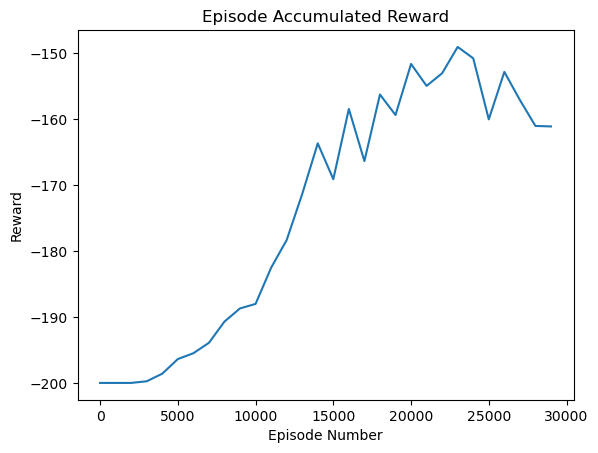

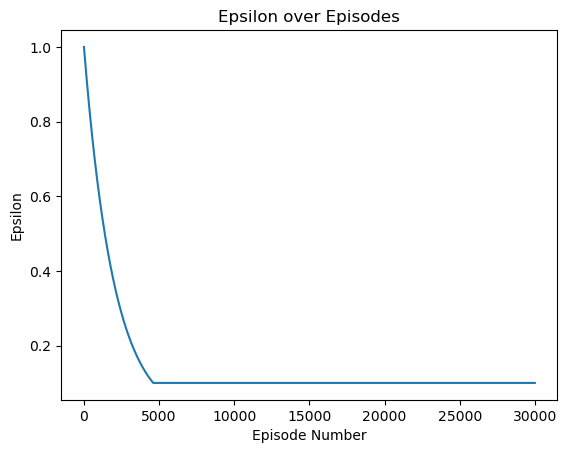

In [19]:
plot_rewards(rewards_ql)
plot_epsilon(epsilons_ql)

In [20]:
Q_LEARNING_VIDEO_TEST = "./videos/q_learning_test"
env_dis = get_env_discretized(record_video=True, record_every=1, folder=Q_LEARNING_VIDEO_TEST)

for episode_num in range(5):
    (pos, vel), info = env_dis.reset()
    episode_over = False
    while not episode_over:
        action = np.argmax(Q_ql[pos, vel])  # Exploit
        (pos, vel), reward, terminated, truncated, info = env_dis.step(action)
        episode_over = terminated or truncated

c:\Users\Octav\anaconda3\envs\obl_taller_ia\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Octav\postgrado\taller ia\Postgrado\Dyna-Q\videos\q_learning_test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [21]:
# Ruta al archivo de vídeo en tu sistema de ficheros
video_path = Q_LEARNING_VIDEO_TEST + "/MountainCar-episode-0.mp4"

# Muestra el vídeo
Video(video_path, embed=True, width=600)

## Dyna-Q

Dyna-Q es un algoritmo que combina el aprendizaje por refuerzo con la planificación. Utiliza la experiencia del agente para actualizar su modelo del entorno y luego simula experiencias adicionales basadas en ese modelo. Esto permite al agente aprender de manera más eficiente al combinar la exploración del entorno real con la explotación de un modelo aprendido.

Preguntas clave que responderemos:
- ¿Cómo modelamos el entorno?
- ¿Cómo actualizamos el modelo del entorno?
- ¿Cómo generamos experiencias simuladas?

$$
\begin{aligned}
\textbf{Dyna-Q (Control TD Off-Policy con Planificación)} \\[6pt]
\textbf{Parámetros:} &\quad \alpha \in (0,1],\;\varepsilon > 0,\;\gamma \in (0,1],\;n \in \mathbb{N}.\\[6pt]
\textbf{Inicializar:} 
&\quad Q(s,a)\;\text{arbitrario para todo }s \in S,\;a \in A(s),\\
&\quad Q(\text{terminal},\cdot) = 0,\\
&\quad \text{Modelo vacío: } Model(s,a)\;\text{indica transición no observada}.\\[6pt]
\textbf{Loop (por cada episodio):} &\\
&\quad \text{Inicializar } S.\\
&\quad \textbf{mientras } S \text{ no sea terminal:}\\
&\quad\quad A \;\leftarrow\; \text{acción seleccionada con política } \varepsilon\text{-greedy respecto a }Q(S,\cdot).\\
&\quad\quad \text{Ejecutar } A,\;\text{observar } R,\;S'.\\
&\quad\quad Q(S,A) \;\leftarrow\; Q(S,A)\;+\;\alpha\,\bigl[\;R \;+\;\gamma\,\max_{a\in A(S')}Q(S',a)\;-\;Q(S,A)\bigr]\\
&\quad\quad \text{Actualizar modelo: } Model(S,A)\;\leftarrow\;(R,\,S').\\
&\quad\quad S \;\leftarrow\; S'.\\
&\quad\quad \textbf{Para } i = 1 \text{ hasta } n: \\
&\quad\quad\quad \text{Elegir } S^*,\,A^* \text{ aleatorios de pares previamente observados}.\\
&\quad\quad\quad (R^*,\,S'^*) \;\leftarrow\; Model(S^*, A^*).\\
&\quad\quad\quad Q(S^*,A^*) \;\leftarrow\; Q(S^*,A^*) \;+\; \alpha\,\bigl[\;R^* \;+\;\gamma\,\max_{a\in A(S'^*)}Q(S'^*,a)\;-\;Q(S^*,A^*)\bigr].\\
\end{aligned}
$$


In [22]:
import random
def dyna_q(env, num_episodes=1000, alpha=0.1, p_alpha=0.01, gamma=0.99, n=5, epsilon_start=1, epsilon_decay=0.9995, epsilon_min=0.1):
    """
    Dyna-Q algorithm for the MountainCar environment.
    
    Args:
        env (gym.Env): The environment to train on.
        num_episodes (int): Number of episodes to train.
        alpha (float): Learning rate.
        gamma (float): Discount factor.
        n (int): number of planning steps.
        epsilon_start (float): Initial exploration rate.
        epsilon_decay (float): Decay rate for exploration.
        epsilon_min (float): Minimum exploration rate.
        
    Returns:
        Q (np.ndarray): The learned Q-table.
        episode_rewards (list): Rewards per episode.
        epsilons (list): Exploration rates per episode.
    """
    # Initialize Q-table
    Q = np.zeros((NUMBER_STATES, NUMBER_STATES, env.action_space.n))
    # Initialize model
    model = {}
    epsilon = epsilon_start
    episode_rewards = []
    epsilons = []
    for _ in tqdm(range(num_episodes)):
        (pos, vel), _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(Q[pos, vel])  # Exploit
            
            # Take action
            (next_pos, next_vel), reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            # Update Q-value
            best_next_action = np.argmax(Q[next_pos, next_vel])
            Q[pos, vel, action] += alpha * (reward + gamma * Q[next_pos, next_vel, best_next_action] - Q[pos, vel, action])

            # Update the model
            model[pos, vel, action] = (reward, next_pos, next_vel)
            memory = list(model.keys())
            # Planning steps
            for _ in range(n):
                (p_pos, p_vel, p_action) = random.choice(memory)
                (p_reward, p_next_pos, p_next_vel) = model[p_pos, p_vel, p_action]
                p_best_next_action = np.argmax(Q[p_next_pos, p_next_vel])
                Q[p_pos, p_vel, p_action] += p_alpha * (p_reward + gamma * Q[p_next_pos, p_next_vel, p_best_next_action] - Q[p_pos, p_vel, p_action]) 
            
            # Update state
            (pos, vel) = (next_pos, next_vel)
            done = terminated or truncated

        episode_rewards.append(episode_reward)
        epsilons.append(epsilon)
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
    

    return Q, episode_rewards, epsilons

In [23]:
env_dis = get_env_discretized(record_video=True, record_every=5_000, folder="./videos/dyna_q_training")
Q_dq, rewards_dq, epsilons_dq = dyna_q(env_dis, num_episodes=NUMBER_EPISODES, n=3)

c:\Users\Octav\anaconda3\envs\obl_taller_ia\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Octav\postgrado\taller ia\Postgrado\Dyna-Q\videos\dyna_q_training folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 30000/30000 [04:21<00:00, 114.67it/s]


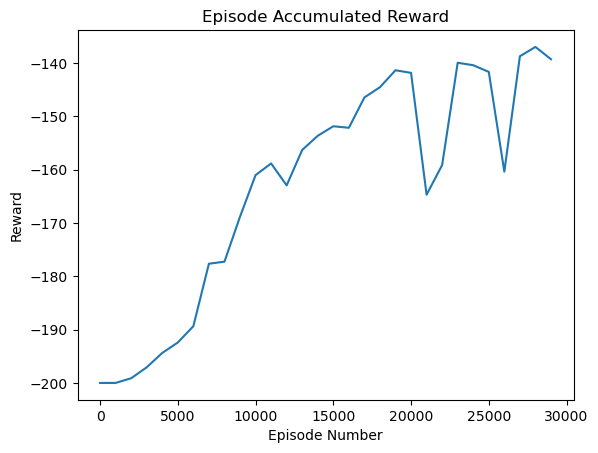

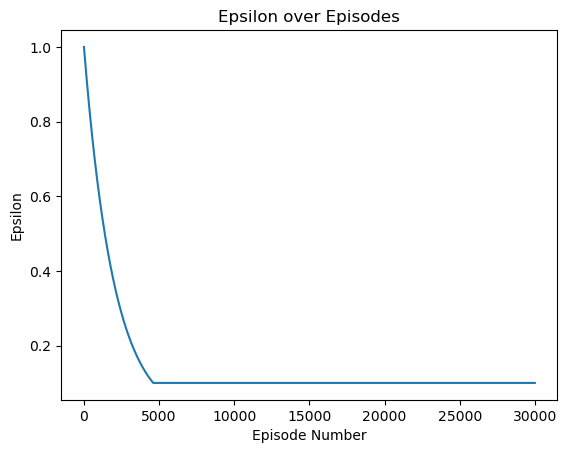

In [24]:
plot_rewards(rewards_dq)
plot_epsilon(epsilons_dq)

In [ ]:
Q_LEARNING_VIDEO_TEST = "./videos/dyna_q__test"
env_dis = get_env_discretized(record_video=True, record_every=1, folder=Q_LEARNING_VIDEO_TEST)

for episode_num in range(5):
    (pos, vel), info = env_dis.reset()
    episode_over = False
    while not episode_over:
        action = np.argmax(Q_dq[pos, vel])  # Exploit
        (pos, vel), reward, terminated, truncated, info = env_dis.step(action)
        episode_over = terminated or truncated

c:\Users\Octav\anaconda3\envs\obl_taller_ia\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Octav\postgrado\taller ia\Postgrado\Dyna-Q\videos\dyna_q__test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [26]:
# Ruta al archivo de vídeo en tu sistema de ficheros
video_path = Q_LEARNING_VIDEO_TEST + "/MountainCar-episode-0.mp4"

# Muestra el vídeo
Video(video_path, embed=True, width=600)

## Tareas

- Comparar el rendimiento de Dyna-Q con Q-learning en el entorno MountainCar.
- Tomar otro entorno de OpenAI Gymnasium y aplicar Dyna-Q.

## Comparación del rendimiento entre Q-Learning y Dyna-Q

In [27]:
# Paso las rewards de ambos modelos a un mismo diccionario.
dict_all_rewards= {}
dict_all_rewards["Q-Learning"] = rewards_ql
dict_all_rewards["Dyna-Q"] = rewards_dq

### Recompensa promedio comparada graficámente

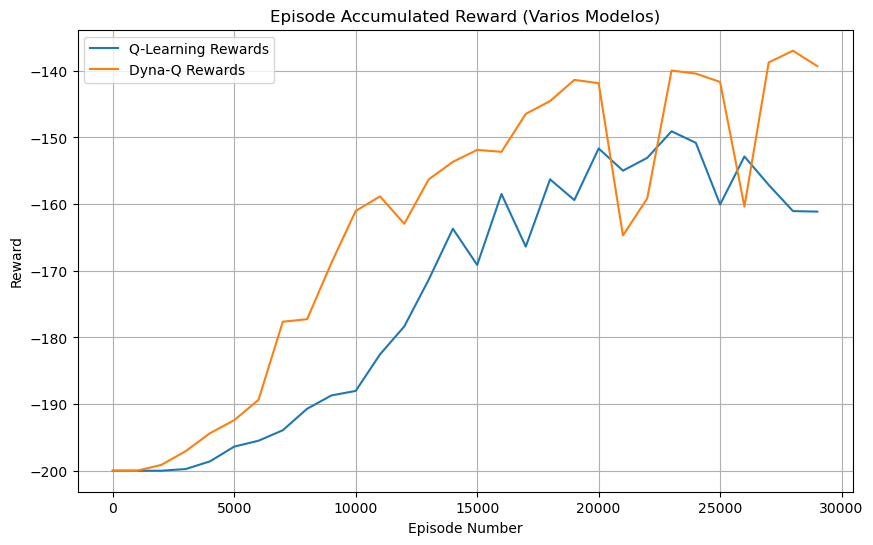

In [28]:
plot_multiple_rewards(dict_all_rewards)

#### Aprendizaje
Comparando los entrenamientos del entorno MountainCar podemos ver como **Dyna-Q**, aprende más rápido que **Q-Learning**.<br>
Los videos compartidos a continuación, son del episodio **20.000** para ambos modelos, reafirman lo visto en el gráfico de recompensas promediadas.

In [29]:
Q_LEARNING_VIDEO_TEST = "./videos/q_learning_training"

# Ruta al archivo de vídeo en tu sistema de ficheros
video_path = Q_LEARNING_VIDEO_TEST + "/MountainCar-episode-20000.mp4"

# Muestra el vídeo
Video(video_path, embed=True, width=600)

In [30]:
DYNA_Q_VIDEO_TEST = "./videos/dyna_q_training"

# Ruta al archivo de vídeo en tu sistema de ficheros
video_path = DYNA_Q_VIDEO_TEST + "/MountainCar-episode-20000.mp4"

# Muestra el vídeo
Video(video_path, embed=True, width=600)

## Experimentación con otro entorno de **Gymnasium**

In [31]:
def get_env_2(record_video=False, record_every=1, folder="./videos" ):
    """
    Create the MountainCar environment with optional video recording and statistics.
    Args:
        record_video (bool): Whether to record video of the episodes.
        record_every (int): Frequency of recording episodes.
        folder (str): Folder to save the recorded videos.
    Returns:
        env (gym.Env): The Car Racing environment.
        
    See also:
        https://gymnasium.farama.org/introduction/record_agent/
    """
    # Initialise the environment
    env =  gym.make("CartPole-v1", render_mode="rgb_array")

    if record_video:
        env = RecordVideo(env, video_folder=folder, name_prefix="CartPole",
                    episode_trigger=lambda x: x % record_every == 0)
    
    return env

In [32]:
def dis_observation_CartPole(obs):
    discretized_obs = []

    car_pos_low, car_pos_high = -2.4, 2.4
    car_vel_low, car_vel_high = -3.0, 3.0
    pol_ang_low, pol_ang_high = -0.2095, 0.2095 
    pol_vel_low, pol_vel_high = -3.0, 3.0

    def scale_clip(x, low, high):
        value = int((x - low) / ((high - low) / NUMBER_STATES))
        return np.clip(value, 0, NUMBER_STATES - 1)

    car_pos_scaled = scale_clip(obs[0], car_pos_low, car_pos_high)
    car_vel_scaled = scale_clip(obs[1], car_vel_low, car_vel_high)
    pol_ang_scaled = scale_clip(obs[2], pol_ang_low, pol_ang_high)
    pol_vel_scaled = scale_clip(obs[3], pol_vel_low, pol_vel_high)
        
    return (car_pos_scaled, car_vel_scaled, pol_ang_scaled, pol_vel_scaled)

In [33]:
def get_env_discretized_2(record_video=False, record_every=1, folder="./videos"):
    base_env = get_env_2(record_video=record_video, record_every=record_every, folder=folder)
    # Discretizar la observación
    new_observation_space = spaces.MultiDiscrete([NUMBER_STATES, NUMBER_STATES, NUMBER_STATES, NUMBER_STATES])
    return TransformObservation(base_env, dis_observation_CartPole, new_observation_space)

In [34]:
env = get_env_2()
obs, info = env.reset()
print(f"Original observation: {obs}")

env_dis = get_env_discretized_2()
obs, _ = env_dis.reset()
print(f"Discretized observation: {obs}")

Original observation: [-0.0246247   0.01105346  0.03180651  0.03078846]
Discretized observation: (np.int64(24), np.int64(24), np.int64(22), np.int64(24))


In [ ]:
env = get_env_2(record_video=True, record_every=1, folder="./videos/random_actions")

env_dis = get_env_discretized_2(record_video=True, record_every=1, folder="./videos/random_actions")

for episode_num in range(5):
    obs, info = env_dis.reset()

    episode_over = False
    while not episode_over:
        action = env_dis.action_space.sample()  # Random action
        obs, reward, terminated, truncated, info = env_dis.step(action)
        episode_over = terminated or truncated

In [36]:
def q_learning_2(env, num_episodes=1000, alpha=0.1, gamma=0.99, epsilon_start=1, epsilon_decay=0.9995, epsilon_min=0.1):
    """
    Q-learning algorithm for the MountainCar environment.
    
    Args:
        env (gym.Env): The environment to train on.
        num_episodes (int): Number of episodes to train.
        alpha (float): Learning rate.
        gamma (float): Discount factor.
        epsilon_start (float): Initial exploration rate.
        epsilon_decay (float): Decay rate for exploration.
        epsilon_min (float): Minimum exploration rate.
        
    Returns:
        Q (np.ndarray): The learned Q-table.
        episode_rewards (list): Rewards per episode.
        epsilons (list): Exploration rates per episode.
    """
    # Initialize Q-table
    Q = np.zeros((NUMBER_STATES, NUMBER_STATES, NUMBER_STATES, NUMBER_STATES, env.action_space.n))
    epsilon = epsilon_start
    episode_rewards = []
    epsilons = []
    for _ in tqdm(range(num_episodes)):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(Q[state])  # Exploit
            
            # Take action
            next_state, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            # Update Q-value
            best_next_action = np.argmax(Q[next_state])
            Q[state + (action,)] += alpha * (reward + gamma * Q[next_state + (best_next_action,)] - Q[state + (action,)])
            # Update state
            state = next_state
            done = terminated or truncated

        episode_rewards.append(episode_reward)
        epsilons.append(epsilon)
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
    

    return Q, episode_rewards, epsilons

In [50]:
def dyna_q_2(env, num_episodes=1000, alpha=0.1, p_alpha=0.01, gamma=0.99, n=5, epsilon_start=1, epsilon_decay=0.9995, epsilon_min=0.1):
    """
    Dyna-Q algorithm for the MountainCar environment.
    
    Args:
        env (gym.Env): The environment to train on.
        num_episodes (int): Number of episodes to train.
        alpha (float): Learning rate.
        gamma (float): Discount factor.
        n (int): number of planning steps.
        epsilon_start (float): Initial exploration rate.
        epsilon_decay (float): Decay rate for exploration.
        epsilon_min (float): Minimum exploration rate.
        
    Returns:
        Q (np.ndarray): The learned Q-table.
        episode_rewards (list): Rewards per episode.
        epsilons (list): Exploration rates per episode.
    """
    # Initialize Q-table
    Q = np.zeros((NUMBER_STATES, NUMBER_STATES, NUMBER_STATES, NUMBER_STATES, env.action_space.n))
    # Initialize model
    model = {}
    epsilon = epsilon_start
    episode_rewards = []
    epsilons = []
    for _ in tqdm(range(num_episodes)):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(Q[state])  # Exploit
            
            # Take action
            next_state, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            # Update Q-value
            best_next_action = np.argmax(Q[next_state])
            Q[state + (action,)] += alpha * (reward + gamma * Q[next_state + (best_next_action,)] - Q[state + (action,)])

            # Update the model
            model[state, action] = (reward, next_state)
            memory = list(model.keys())
            # Planning steps
            for _ in range(n):
                (p_state, p_action) = random.choice(memory)
                (p_reward, p_next_state) = model[p_state, p_action]
                p_best_next_action = np.argmax(Q[p_next_state])
                Q[p_state + (p_action,)] += p_alpha * (p_reward + gamma * Q[p_next_state + (p_best_next_action,)] - Q[p_state + (p_action,)]) 
            
            # Update state
            (state) = (next_state)
            done = terminated or truncated

        episode_rewards.append(episode_reward)
        epsilons.append(epsilon)
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
    

    return Q, episode_rewards, epsilons

In [51]:
NUMBER_EPISODES = 30_000
NUMBER_STATES = 10

env_dis = get_env_discretized_2(record_video=True, record_every=10_000, folder="./videos/q_learning_training")
Q_ql_2, rewards_ql_2, epsilons_ql_2 = q_learning_2(env_dis, num_episodes=NUMBER_EPISODES)

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [05:34<00:00, 89.73it/s] 


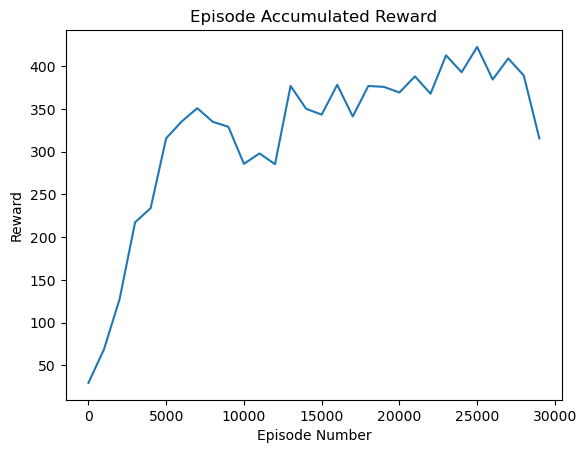

In [54]:
plot_rewards(rewards_ql_2)

In [55]:
env_dis = get_env_discretized_2(record_video=True, record_every=10_000, folder="./videos/dyna_q_training")
Q_dq_2, rewards_dq_2, epsilons_dq_2 = dyna_q_2(env_dis, num_episodes=NUMBER_EPISODES, n=3)

c:\Users\Octav\anaconda3\envs\obl_taller_ia\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Octav\postgrado\taller ia\Postgrado\Dyna-Q\videos\dyna_q_training folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 30000/30000 [07:30<00:00, 66.52it/s] 


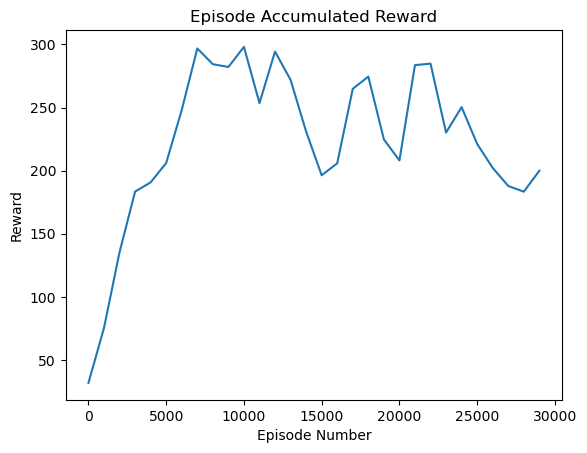

In [63]:
plot_rewards(rewards_dq_2)

In [64]:
Q_LEARNING_VIDEO_TEST = "./videos/q_learning_test"
env_dis = get_env_discretized_2(record_video=True, record_every=1, folder=Q_LEARNING_VIDEO_TEST)

for episode_num in range(5):
    state, _ = env_dis.reset()
    episode_over = False
    while not episode_over:
        action = np.argmax(Q_ql_2[state])  # Exploit
        state, reward, terminated, truncated, _ = env_dis.step(action)
        episode_over = terminated or truncated

c:\Users\Octav\anaconda3\envs\obl_taller_ia\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Octav\postgrado\taller ia\Postgrado\Dyna-Q\videos\q_learning_test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Users\Octav\anaconda3\envs\obl_taller_ia\Lib\site-packages\gymnasium\wrappers\rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


In [65]:
DYNA_Q_VIDEO_TEST = "./videos/dyna_q__test"
env_dis = get_env_discretized_2(record_video=True, record_every=1, folder=DYNA_Q_VIDEO_TEST)

for episode_num in range(5):
    state, _ = env_dis.reset()
    episode_over = False
    while not episode_over:
        action = np.argmax(Q_dq_2[state])  # Exploit
        state, reward, terminated, truncated, _ = env_dis.step(action)
        episode_over = terminated or truncated

c:\Users\Octav\anaconda3\envs\obl_taller_ia\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Octav\postgrado\taller ia\Postgrado\Dyna-Q\videos\dyna_q__test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
